## _Inference after DNN Stage_

**_Inference_** is done using callbacks defined in the **_LightningModules/GNN/Models/inference.py_**. The callbacks run during the **_test_step()_** _a.k.a_ model _**evalution**_.

### How to run _Inference_?

1. _`traintrack config/pipeline_quickstart.yaml`_. One can use `--inference` flag to run only the `test_step()` (Should work, but failed.)
2. _`infer.ipynb`_ notebook runs the _pl.Trainer().test()_

In [1]:
import sys, os, glob, yaml

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pprint
from tqdm import tqdm
import trackml.dataset

In [4]:
import torch
import torchmetrics
import pytorch_lightning as pl
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import itertools

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
os.environ['EXATRKX_DATA'] = os.path.abspath(os.curdir)

In [7]:
from LightningModules.DNN import EdgeClassifier, EdgeClassifier_BN, EdgeClassifier_LN
from LightningModules.DNN import GNNBuilder, GNNMetrics
from LightningModules.DNN.Models.infer import GNNTelemetry

## _Classifier Evaluation_

Metrics to evaluate the GNN networks:

- Accuracy/ACC = $TP+TN/TP+TN+FP+FN$
- sensitivity, recall, hit rate, or true positive rate ($TPR = 1 - FNR$)
- specificity, selectivity or true negative rate ($TNR = 1 - FPR$)
- miss rate or false negative rate ($FNR = 1 - TPR$)
- fall-out or false positive rate ($FPR = 1 - TNR$)
- F1-score = $2 \times (\text{PPV} \times \text{TPR})/(\text{PPV} + \text{TPR})$
- Efficiency/Recall/Sensitivity/Hit Rate: $TPR = TP/(TP+FN)$
- Purity/Precision/Positive Predictive Value: $PPV = TP/(TP+FP$
- AUC-ROC Curve $\equiv$ FPR ($x-$axis) v.s. TPR ($y-$axis) plot
- AUC-PRC Curve $\equiv$ TPR ($x-$axis) v.s. PPV ($y-$axis) plot


Use `tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()` to directly access TN, FP, FN and TP using Scikit-learn.

### _Test Dataset_

### _Load Checkpoint_

Lightning automatically saves a checkpoint for you in your current working directory, with the state of your last training epoch. We have checkpoint stored after training is finished.

```
# load a LightningModule along with its weights & hyperparameters from a checkpoint
model = MyLightningModule.load_from_checkpoint("/path/to/checkpoint.ckpt")
print(model.input_dir)
```

Note that we have saved our hyperparameters when our **LightningModule** was initialized i.e. `self.save_hyperparameters(hparams)`

```
# hyperparameters are saved to the “hyper_parameters” key in the checkpoint, to access them
checkpoint = torch.load(path/to/checkpoint, map_location=device)
print(checkpoint["hyper_parameters"])
```

One can also initialize the model with different hyperparameters (if they are saved).


For more details, consult [Lighting Checkpointing](https://pytorch-lightning.readthedocs.io/en/stable/common/checkpointing.html).

### _Get Checkpoint Hparams_

- Either from the configs folder 
- Or extract it from the checkpoint, favoured if model is trained and evaluated on two different machines.

In [8]:
# load processing config file (trusted source)
config = None
config_file = os.path.join(os.curdir, 'LightningModules/DNN/configs/train_alldata_DNN.yaml')
with open(config_file) as f:
    try:
        config = yaml.load(f, Loader=yaml.FullLoader) # equiv: yaml.full_load(f)
    except yaml.YAMLError as e:
        print(e)

In [9]:
# print(config)

In [10]:
# Load Model Checkpoint
ckpnt_path = "run_all/lightning_models/lightning_checkpoints/DNNStudy/version_0/checkpoints/last.ckpt"

# Dense with BatchNorm: [128,512,128,1024,512,1]
# ckpnt_path = "run_all/lightning_models/lightning_checkpoints/DNNStudy/j0yu0omr/checkpoints/last.ckpt"

# Dense with LayerNorm: [128,128,1024,1024,128,1]
# ckpnt_path = "run_all/lightning_models/lightning_checkpoints/DNNStudy/avvy18g5/checkpoints/last.ckpt"

checkpoint = torch.load(ckpnt_path, map_location=device)
config = checkpoint["hyper_parameters"]

In [11]:
print(checkpoint["hyper_parameters"])

{'input_dir': '/global/cscratch1/sd/aakram/run_all/feature_store', 'output_dir': '/global/cscratch1/sd/aakram/run_all/dnn_processed', 'project': 'DNNStudy', 'edge_cut': 0.5, 'pt_signal_min': 0.0, 'pt_background_min': 0.0, 'datatype_names': ['train', 'val', 'test'], 'datatype_split': [90000, 5000, 5000], 'train_split': [90000, 5000, 5000], 'sorted_events': True, 'noise': False, 'overwrite': True, 'n_workers': 8, 'spatial_channels': 3, 'cell_channels': 0, 'hidden': 128, 'n_graph_iters': 8, 'nb_node_layer': 3, 'nb_edge_layer': 3, 'emb_channels': 0, 'layernorm': True, 'batchnorm': False, 'directed': True, 'batchsize': 128, 'aggregation': 'sum_max', 'hidden_activation': 'ReLU', 'weight': 2, 'warmup': 200, 'lr': 0.001, 'factor': 0.3, 'patience': 10, 'regime': 'pid', 'max_epochs': 50, 'callbacks': 'GNNBuilder', 'resume_id': 'avvy18g5', 'logger': 'wandb', 'model_library': 'LightningModules', 'artifact_library': '/global/cscratch1/sd/aakram/run/lightning_models/lightning_checkpoints', 'set': 'D

In [12]:
# View Hyperparameters
# print(config)

In [13]:
# One Can Modify Hyperparameters
config["checkpoint_path"] = ckpnt_path
config["input_dir"] = "run_all/feature_store"
config["output_dir"] = "run_all/dnn_processed"
config["artifact_library"] = "lightning_models/lightning_checkpoints"
config["train_split"] = [0, 0, 10000]
config["map_location"] = device

In [14]:
# View Hyperparameters (Modified)
print(config)

{'input_dir': 'run_all/feature_store', 'output_dir': 'run_all/dnn_processed_ln', 'project': 'DNNStudy', 'edge_cut': 0.5, 'pt_signal_min': 0.0, 'pt_background_min': 0.0, 'datatype_names': ['train', 'val', 'test'], 'datatype_split': [90000, 5000, 5000], 'train_split': [0, 0, 10000], 'sorted_events': True, 'noise': False, 'overwrite': True, 'n_workers': 8, 'spatial_channels': 3, 'cell_channels': 0, 'hidden': 128, 'n_graph_iters': 8, 'nb_node_layer': 3, 'nb_edge_layer': 3, 'emb_channels': 0, 'layernorm': True, 'batchnorm': False, 'directed': True, 'batchsize': 128, 'aggregation': 'sum_max', 'hidden_activation': 'ReLU', 'weight': 2, 'warmup': 200, 'lr': 0.001, 'factor': 0.3, 'patience': 10, 'regime': 'pid', 'max_epochs': 50, 'callbacks': 'GNNBuilder', 'resume_id': 'avvy18g5', 'logger': 'wandb', 'model_library': 'LightningModules', 'artifact_library': 'lightning_models/lightning_checkpoints', 'set': 'DNN', 'name': 'EdgeClassifier', 'config': 'train_alldata_DNN.yaml', 'batch_config': 'configs

### _Get Checkpoint Model_

In [15]:
# Init EdgeClassifier with New Config
model = EdgeClassifier(config)

In [16]:
# Load Checkpoint with New Config (It will Provide Path and Other Parameters, Most will be Overwritten)
model = model.load_from_checkpoint(**config)

### _(1) - Inference: Callbacks_

* _Test with LightingModule_

In [17]:
# Lightning Trainer
# trainer = pl.Trainer(callbacks=[GNNTelemetry()])

In [18]:
# Run TestStep
# trainer.test(model=model, verbose=True)

* _Test with LightningDataModule_

In [19]:
# from Predict import SttDataModule

In [20]:
# Prepare LightningDataModule
# dm = SttDataModule(config)

In [21]:
# dm.setup(stage='test')
# test_dataloaders = dm.test_dataloader

In [22]:
# Run TestStep with LightningDataModule
# trainer.test(model=model, dataloaders=None, ckpt_path=None, verbose=True, datamodule=dm)

### _(2) - Inference: Manual_

In [23]:
from Predict import eval_model

- How to get data using LightningModuel?

In [24]:
# run setup() for datasets
model.setup(stage="fit")

Loading data to 'cpu'
Trainset: 0, Valset: 0, Testset: 10000



In [25]:
# Method 1: Directly Get Test Dataset
# testset = model.testset

# Get singel Batch
# batch = testset[0]

# OR, loop over
# for index, batch in enumerate(testset):
# for batch in testset:
#    print(index, batch)

In [26]:
# Method 2: Directly Get Test Dataloader
# test_dataloader = model.test_dataloader()

# Get singel Batch
# batch = next(iter(test_dataloader))

# OR, loop over
# for batch_idx, batch in enumerate(test_dataloader):
# for batch in test_dataloader:
#    print(batch)

In [27]:
# get testset or test_dataloader
testset = model.testset
test_dataloader = model.test_dataloader()

In [28]:
# evaluate model, returns torch tensors
scores, truths = eval_model(model, test_dataloader)

Processed Batches:  0
Processed Batches:  1000
Processed Batches:  2000
Processed Batches:  3000
Processed Batches:  4000
Processed Batches:  5000
Processed Batches:  6000
Processed Batches:  7000
Processed Batches:  8000
Processed Batches:  9000


In [29]:
# save scores and truths as .npy files
np.save("dnn_scores.npy", scores.numpy())
np.save("dnn_truths.npy", truths.numpy())

In [30]:
# torch to numpy
scores = scores.numpy()
truths = truths.numpy()

### _Evaluation Metrics_

In [31]:
from src.metric_utils import compute_metrics, plot_metrics, plot_outputs_roc, plot_model_output

In [32]:
metrics = compute_metrics(scores,truths,threshold=0.5)

In [33]:
# Curves
# metrics.prc_precision, metrics.prc_recall, metrics.prc_thresh
# metrics.roc_tpr, metrics.roc_fpr, metrics.roc_thresh

In [34]:
metrics.accuracy

0.9604557744728703

In [35]:
metrics.recall

0.9041607861085419

In [36]:
metrics.precision

0.8994830925543738

In [37]:
metrics.f1

0.9018158736060545

### _(a) - Plot Metrics_

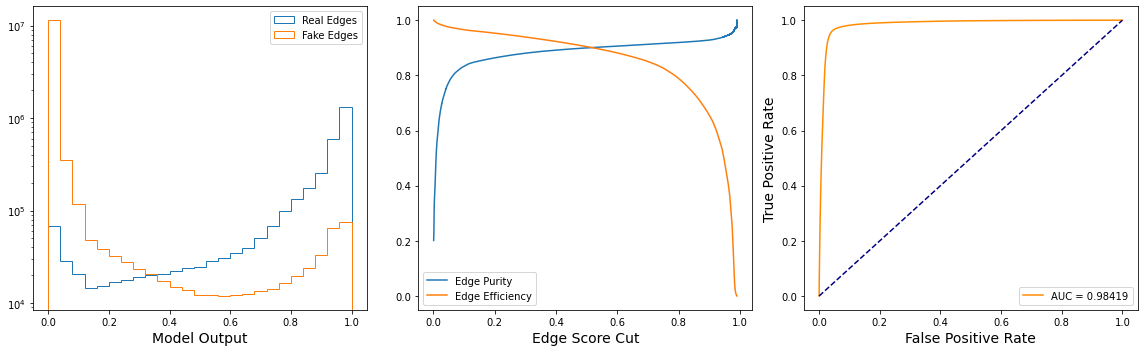

In [38]:
plot_metrics(scores,truths, metrics, name="dnn")

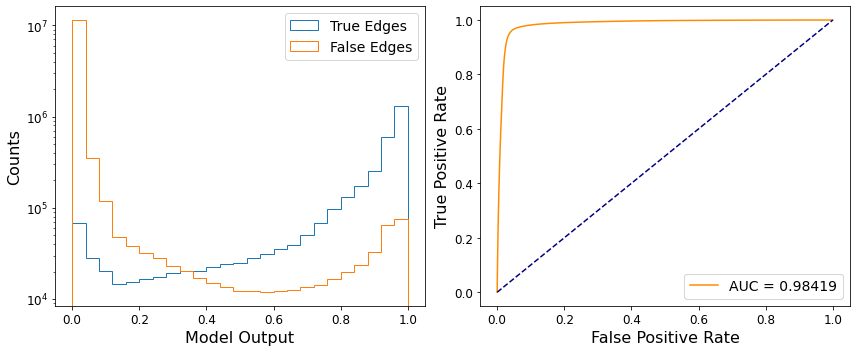

In [39]:
plot_outputs_roc(scores,truths, metrics, name="dnn")

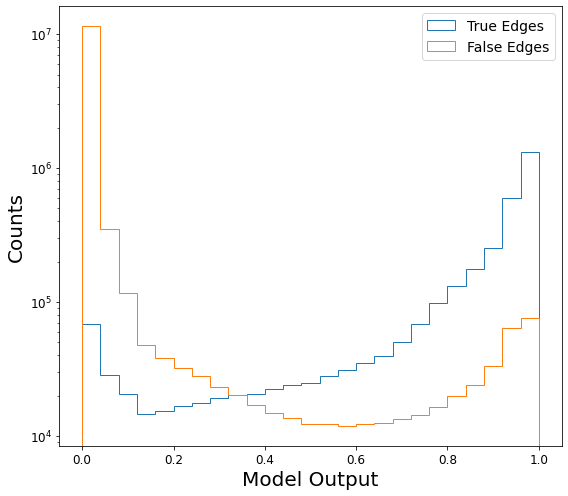

In [40]:
plot_model_output(scores, truths, name="dnn")

### _(b) - S/B Suppression_

Background rejection rate (1/FPR) is given as $1/\epsilon_{bkg}$ where $\epsilon_{bkg}$ is the fraction of fake edges that pass the classification requirement. Signal efficiency (TPR ~ Recall) ($\epsilon_{sig}$) is defined as the number of true edges above a given classification score cut over the total number of true edges. What we have?

- Signal Efficiency = $\epsilon_{sig}$ = TPR ~ Recall 
- Background Rejection = $1 - \epsilon_{bkg}$ ???
- Background Rejection Rate = $1/\epsilon_{bkg}$ = 1/FPR


First apply a edge score cut to binarized the `scores`, we will call it `preds`. The count number of false or true edges that pass this cut. Then calculated background rejection rate and signal efficiency. For making a plot one can do calculations in batch by batch mode on the test dataset.

In [41]:
sig = metrics.roc_tpr

In [42]:
bkg_rejection = 1/metrics.roc_fpr

/tmp/ipykernel_338650/2780880391.py:1: RuntimeWarning: divide by zero encountered in true_divide
  bkg_rejection = 1/metrics.roc_fpr


In [43]:
# cut off eff < 0.2 or 0.5
sig_mask = sig > 0.3

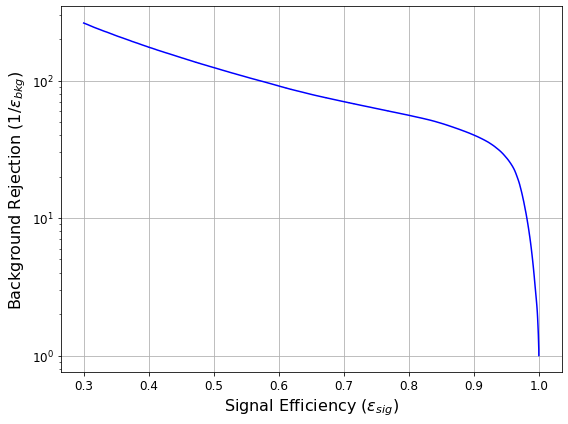

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
ax.plot(sig[sig_mask], bkg_rejection[sig_mask], color="blue")

# Axes Params
ax.set_xlabel("Signal Efficiency ($\epsilon_{sig}$)", fontsize=16)
ax.set_ylabel("Background Rejection ($1/\epsilon_{bkg}$)", fontsize=16)
ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.grid(True)

# Figure Params
fig.tight_layout()
fig.savefig("dnn_SB.pdf")

### _Plot Test Event_